In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
import matplotlib.pyplot as plt
import random

## Data generation

In [3]:
 #Set seeds for reproducibility
def set_seed(seed=42):
    """
    Set seeds for reproducibility across Python, NumPy and PyTorch
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed} for reproducibility")

In [6]:
# Select device: GPU (if available) otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
set_seed(0)
########################################################
# True Solution, Coefficient, and Source Term
########################################################
def true_u(x, y):
    """u(x,y) = sin(pi*x)*sin(pi*y)"""
    return np.sin(np.pi*x) * np.sin(np.pi*y)

def true_a(x, y):
    """a(x,y)= 1/(1+x^2+y^2+(x-1)^2+(y-1)^2)"""
    return 1.0 / (1.0 + x**2 + y**2 + (x-1)**2 + (y-1)**2)

def f_func(x, y):
    """
    According to equation (105):
      f = 2*pi^2*sin(pi*x)*sin(pi*y)/(1+...) 
          + 2*pi*((2*x-1)*cos(pi*x)*sin(pi*y) + (2*y-1)*sin(pi*x)*cos(pi*y))/(1+...)^2
    This is a sample implementation. Please adjust according to the actual formula.
    """
    denom = 1.0 + x**2 + y**2 + (x-1)**2 + (y-1)**2
    part1 = 2 * (np.pi**2) * np.sin(np.pi*x) * np.sin(np.pi*y) / denom
    cosx = np.cos(np.pi*x)
    siny = np.sin(np.pi*y)
    part2 = 2 * np.pi * (((2*x-1)*cosx*siny) + ((2*y-1)*np.sin(np.pi*x)*np.cos(np.pi*y))) / (denom**2)
    fval = part1 + part2
    return fval

########################################################
# Data Generation
########################################################
def generate_mixed_labeled_data(nx=50, ny=50, noise_noisy=1.0, noise_clean=0.0, noise_ratio=2/5):
    """
    Generate a 50x50 grid on [0,1]^2 with 2500 points.
    For each point, randomly choose between clean labels (noise=0.01) and noisy labels (noise=1.0) in a 2:3 ratio.
    """
    x_vals = np.linspace(0, 1, nx)
    y_vals = np.linspace(0, 1, ny)
    xx, yy = np.meshgrid(x_vals, y_vals)
    X = np.stack([xx.ravel(), yy.ravel()], axis=-1)  # shape: [2500, 2]
    u_true_vals = true_u(xx.ravel(), yy.ravel())
    u_true_vals = torch.tensor(u_true_vals.reshape(-1, 1), dtype=torch.float32)
    total_points = nx * ny
    noisy_N = int(noise_ratio * total_points)
    # Shuffle indices
    indices = torch.randperm(total_points)
    noisy_idx = indices[:noisy_N]
    clean_idx = indices[noisy_N:]
    u_obs = u_true_vals.clone()
    
    # 
    u_obs[clean_idx] += noise_clean * torch.randn_like(u_true_vals[clean_idx])
    u_obs[noisy_idx] += noise_noisy * torch.randn_like(u_true_vals[noisy_idx])
    return torch.tensor(X, dtype=torch.float32), u_obs

def generate_collocation_points(num_pde=8192):
    X_pde = np.random.rand(num_pde, 2)
    return torch.tensor(X_pde, dtype=torch.float32)

def generate_boundary_points(num_bdy=2048):
    """
    Generate boundary points on [0,1]^2 where u=0 and a equals true_a(x,y)
    """
    X_b = []
    for _ in range(num_bdy):
        side = np.random.choice([0, 1, 2, 3])
        if side == 0:   # x = 0
            x_ = 0.0
            y_ = np.random.rand()
        elif side == 1: # x = 1
            x_ = 1.0
            y_ = np.random.rand()
        elif side == 2: # y = 0
            x_ = np.random.rand()
            y_ = 0.0
        else:           # y = 1
            x_ = np.random.rand()
            y_ = 1.0
        X_b.append([x_, y_])
    X_b = np.array(X_b)
    a_b = true_a(X_b[:, 0], X_b[:, 1])
    u_b = np.zeros_like(a_b)  # u = 0
    return (torch.tensor(X_b, dtype=torch.float32),
            torch.tensor(u_b.reshape(-1, 1), dtype=torch.float32),
            torch.tensor(a_b.reshape(-1, 1), dtype=torch.float32))

# (1) Generate noisy data (2500 points)
# X_data, u_data = generate_data_points(nx=50, ny=50, noise_level=1.0)
X_data, u_data = generate_mixed_labeled_data(nx=50, ny=50,  noise_noisy=1.0, noise_clean=0.01, noise_ratio=3/5)
X_data, u_data = X_data.to(device), u_data.to(device)
# (2) PDE collocation points (8192)
X_pde = generate_collocation_points(num_pde=8192).to(device)
# (3) Boundary points (2048) -- on the boundary, u=0 and a equals true_a
X_b, u_b, a_b = generate_boundary_points(num_bdy=2048)
X_b, u_b, a_b = X_b.to(device), u_b.to(device), a_b.to(device)

print("X_data:", X_data.shape, "u_data:", u_data.shape)
print("X_pde:", X_pde.shape)
print("X_b:", X_b.shape, "u_b:", u_b.shape, "a_b:", a_b.shape)

Random seed set to 0 for reproducibility
X_data: torch.Size([2500, 2]) u_data: torch.Size([2500, 1])
X_pde: torch.Size([8192, 2])
X_b: torch.Size([2048, 2]) u_b: torch.Size([2048, 1]) a_b: torch.Size([2048, 1])


## baseline-pinn training

In [8]:
# 1. Define the Network: Output Both [u, a]
########################################################
class InversePoissonNet(nn.Module):
    """
    Learn the PDE solution u(x,y) and coefficient field a(x,y) simultaneously.
    The output's first component corresponds to u and the second to a.
    Hidden layers: 5 layers, each with 100 neurons and tanh activation.
    """
    def __init__(self, in_dim=2, hidden_dim=100, hidden_layers=5, out_dim=2):
        super(InversePoissonNet, self).__init__()
        layers = []
        # Input layer
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.Tanh())
        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        # Output layer
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)  # shape: [N,2], corresponding to [u, a]

    def get_activation(self, x, layer_index):
        """Get the activation values from the specified layer (for selective pruning)"""
        activation = None
        def hook(module, input, output):
            nonlocal activation
            activation = output
        handle = self.net[layer_index].register_forward_hook(hook)
        _ = self.net(x)
        handle.remove()
        return activation
########################################################
def pde_residual(model, x):
    """
    x: [N,2]; model outputs [u, a]
    """
    x_ = x.clone().detach().requires_grad_(True)
    out = model(x_)
    u = out[:, 0:1]
    a = out[:, 1:2]
    # Compute ∇u
    grads_u = torch.autograd.grad(u, x_, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads_u[:, 0:1]
    u_y = grads_u[:, 1:2]
    # Compute gradients of a*u_x and a*u_y
    a_u_x = a * u_x
    a_u_y = a * u_y
    grads_aux = torch.autograd.grad(a_u_x, x_, grad_outputs=torch.ones_like(a_u_x), create_graph=True)[0]
    grads_auy = torch.autograd.grad(a_u_y, x_, grad_outputs=torch.ones_like(a_u_y), create_graph=True)[0]
    div_term = grads_aux[:, 0:1] + grads_auy[:, 1:2]

    # Compute f(x,y) using f_func; convert x_ to numpy and then back to tensor
    xy = x_.detach().cpu().numpy()
    fx = f_func(xy[:, 0], xy[:, 1])
    f_val = torch.tensor(fx, dtype=torch.float32).unsqueeze(-1).to(x_.device)

    return -div_term - f_val

########################################################
# 5. Loss Function: Data Loss + PDE Residual Loss + Boundary Loss
########################################################
def loss_fn(model, X_data, u_data, X_pde, X_b, u_b, a_b,
            lambda_pde=1.0, lambda_b=1.0):
    mse = nn.MSELoss()
    # Data loss: fit u_pred to noisy u_data
    out_data = model(X_data)
    u_pred_data = out_data[:, 0:1]
    loss_data = mse(u_pred_data, u_data)
    # PDE residual loss
    r_pde = pde_residual(model, X_pde)
    loss_pde = mse(r_pde, torch.zeros_like(r_pde))
    # Boundary loss: enforce u=0 and a equals true a_b on the boundary
    out_bdy = model(X_b)
    u_pred_bdy = out_bdy[:, 0:1]
    a_pred_bdy = out_bdy[:, 1:2]
    loss_bdy_u = mse(u_pred_bdy, u_b)
    loss_bdy_a = mse(a_pred_bdy, a_b)
    loss_bdy = loss_bdy_u + loss_bdy_a

    total_loss = loss_data + lambda_pde * loss_pde + lambda_b * loss_bdy
    return total_loss, loss_data, loss_pde, loss_bdy

########################################################
# 6. Initial Training (20,000 epochs)
########################################################
def train_model(model, X_data, u_data, X_pde, X_b, u_b, a_b,
                epochs=20000, lr=1e-3, lambda_pde=1.0, lambda_b=1.0, device="cpu"):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    for epoch in range(epochs):
        optimizer.zero_grad()
        L, L_data, L_pde, L_bdy = loss_fn(model, X_data, u_data, X_pde, X_b, u_b, a_b,
                                          lambda_pde, lambda_b)
        L.backward()
        optimizer.step()
        if epoch % 2000 == 0:
            print(f"Epoch {epoch}: total={L.item():.4e}, data={L_data.item():.4e}, pde={L_pde.item():.4e}, bdy={L_bdy.item():.4e}")
    return model

In [9]:
set_seed(0)
# train
model = InversePoissonNet(in_dim=2, hidden_dim=100, hidden_layers=5, out_dim=2).to(device)
print("Starting initial training (20,000 epochs)...")
model = train_model(model, X_data, u_data, X_pde, X_b, u_b, a_b,
                    epochs=20000, lr=1e-3, lambda_pde=1.0, lambda_b=1.0)

Random seed set to 0 for reproducibility
Starting initial training (20,000 epochs)...
Epoch 0: total=1.9079e+01, data=7.4830e-01, pde=1.8107e+01, bdy=2.2354e-01
Epoch 2000: total=5.7749e-01, data=5.7194e-01, pde=7.4266e-04, bdy=4.8045e-03
Epoch 4000: total=5.7393e-01, data=5.7143e-01, pde=5.5049e-04, bdy=1.9445e-03
Epoch 6000: total=5.7447e-01, data=5.7148e-01, pde=1.9704e-03, bdy=1.0199e-03
Epoch 8000: total=5.7242e-01, data=5.7152e-01, pde=3.3194e-04, bdy=5.6827e-04
Epoch 10000: total=5.7217e-01, data=5.7156e-01, pde=1.8317e-04, bdy=4.2018e-04
Epoch 12000: total=5.7244e-01, data=5.7172e-01, pde=3.5202e-04, bdy=3.7239e-04
Epoch 14000: total=5.7304e-01, data=5.7157e-01, pde=1.0907e-03, bdy=3.7890e-04
Epoch 16000: total=5.7782e-01, data=5.7160e-01, pde=5.8228e-03, bdy=3.9168e-04
Epoch 18000: total=5.7404e-01, data=5.7149e-01, pde=2.1563e-03, bdy=3.9821e-04


Final: rel_u=0.018399, rel_a=0.031043


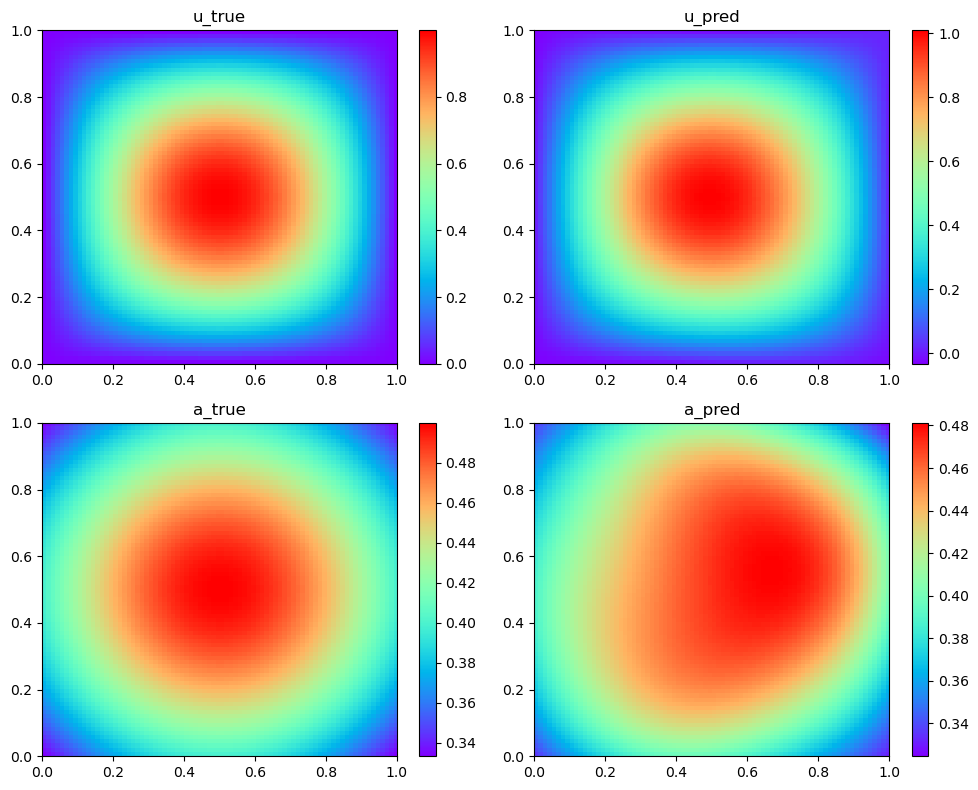

In [11]:
def evaluate_model(model, nx=100, ny=100):
    x_vals = np.linspace(0, 1, nx)
    y_vals = np.linspace(0, 1, ny)
    xx, yy = np.meshgrid(x_vals, y_vals)
    X_test = np.stack([xx.ravel(), yy.ravel()], axis=-1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(next(model.parameters()).device)
    model.eval()
    with torch.no_grad():
        out = model(X_test_t)
    
    # Predictions
    u_pred = out[:, 0].cpu().numpy().reshape(nx, ny)
    a_pred = out[:, 1].cpu().numpy().reshape(nx, ny)
    
    # True values
    u_true_vals = true_u(xx, yy)
    a_true_vals = true_a(xx, yy)
    
    # Compute u error metrics
    u_diff = u_pred - u_true_vals
    l2re_u = np.sqrt(np.sum(u_diff**2)) / np.sqrt(np.sum(u_true_vals**2))  # L2 relative error
    l1re_u = np.sum(np.abs(u_diff)) / np.sum(np.abs(u_true_vals))           # L1 relative error
    mse_u = np.mean(u_diff**2)                                               # Mean squared error
    max_err_u = np.max(np.abs(u_diff))                                       # Maximum absolute error
    
    # Compute a error metrics
    a_diff = a_pred - a_true_vals
    l2re_a = np.sqrt(np.sum(a_diff**2)) / np.sqrt(np.sum(a_true_vals**2))    # L2 relative error
    l1re_a = np.sum(np.abs(a_diff)) / np.sum(np.abs(a_true_vals))            # L1 relative error
    mse_a = np.mean(a_diff**2)                                               # Mean squared error
    max_err_a = np.max(np.abs(a_diff))                                       # Maximum absolute error
    
    return (
        (l2re_u, l1re_u, mse_u, max_err_u),   # u metrics
        (l2re_a, l1re_a, mse_a, max_err_a),   # a metrics
        u_pred, a_pred, u_true_vals, a_true_vals  # raw data
    )
(u_metrics_a, a_metrics_a, u_pred, a_pred, u_true, a_true) = evaluate_model(model, nx=80, ny=80)
l2re_u, l1re_u, mse_u, max_err_u = u_metrics_a
l2re_a, l1re_a, mse_a, max_err_a = a_metrics_a
print(f"Final: rel_u={l2re_u:.6f}, rel_a={l2re_a:.6f}")

# (7) Visualization of results
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
im0 = axs[0, 0].imshow(u_true, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='rainbow')
axs[0, 0].set_title("u_true")
im1 = axs[0, 1].imshow(u_pred, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='rainbow')
axs[0, 1].set_title("u_pred")
im2 = axs[1, 0].imshow(a_true, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='rainbow')
axs[1, 0].set_title("a_true")
im3 = axs[1, 1].imshow(a_pred, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='rainbow')
axs[1, 1].set_title("a_pred")
plt.colorbar(im0, ax=axs[0, 0])
plt.colorbar(im1, ax=axs[0, 1])
plt.colorbar(im2, ax=axs[1, 0])
plt.colorbar(im3, ax=axs[1, 1])
plt.tight_layout()
plt.show()

## data-partition and selective-pruning

In [12]:
########################################################
def partition_data_by_u_mixed(model, X_data, u_data, threshold=0.01, weight_data=1.0, weight_res=1.0):
    """
    Partition the data based on a mixed loss that combines the data loss and the squared PDE residual loss.
    The mixed loss for each data point is computed as:
        mixed_loss = weight_data * (u_pred - u_data)^2 + weight_res * (pde_residual)^2.
    Data points with mixed_loss less than the threshold are considered as retain data.
    """
    model.eval()
    # Ensure gradients are enabled for PDE residual computation
    with torch.enable_grad():
        out = model(X_data)
        u_pred = out[:, 0:1]
        res = pde_residual(model, X_data)
    
    # Compute squared errors
    data_errors = (u_pred - u_data) ** 2
    res_errors = res ** 2
    # Compute combined error with given weights
    combined_errors = weight_data * data_errors + weight_res * res_errors
    combined_errors = combined_errors.squeeze().cpu().detach().numpy()
    
    good_idx = np.where(combined_errors < threshold)[0]
    bad_idx = np.where(combined_errors >= threshold)[0]
    print(f"Mixed error threshold: {threshold:.6f}, Good points = {len(good_idx)}, Bad points = {len(bad_idx)}")
    
    X_good = X_data[good_idx]
    u_good = u_data[good_idx]
    X_bad = X_data[bad_idx]
    u_bad = u_data[bad_idx]
    return (X_good, u_good), (X_bad, u_bad)

########################################################
# 8. Pruning Operation
########################################################
def prune_neuron(model, layer_index, neuron_idx):
    linear_layer = model.net[layer_index]
    next_layer = None
    for i in range(layer_index + 1, len(model.net)):
        if isinstance(model.net[i], nn.Linear):
            next_layer = model.net[i]
            break
    if next_layer is None:
        print("No subsequent linear layer found, skipping pruning")
        return
    with torch.no_grad():
        linear_layer.weight[neuron_idx, :] = 0.0
        if linear_layer.bias is not None:
            linear_layer.bias[neuron_idx] = 0.0
        next_layer.weight[:, neuron_idx] = 0.0

def selective_pruning_layer(model, layer_index, retain_data, forget_data, alpha=0.01, num_iter=3):
    X_good = retain_data[0]
    X_bad = forget_data[0]
    for it in range(num_iter):
        acts_good = model.get_activation(X_good, layer_index).detach().cpu().numpy()
        acts_bad = model.get_activation(X_bad, layer_index).detach().cpu().numpy()
        num_neuron = acts_good.shape[1]
        scores = np.zeros(num_neuron)
        for n in range(num_neuron):
            mg = np.mean(acts_good[:, n])
            mb = np.mean(acts_bad[:, n])
            scores[n] = mb - mg
        c = np.mean(np.abs(np.concatenate([acts_good, acts_bad], axis=0))) + 1e-8
        scores /= c
        k = int(alpha * num_neuron)
        prune_idx = np.argsort(scores)[-k:]
        print(f"Iter {it}: Pruning neurons = {prune_idx}, scores = {scores[prune_idx]}")
        for idx in prune_idx:
            prune_neuron(model, layer_index, idx)
    return model

def selective_pruning_multi_layers(model, layer_indices, retain_data, forget_data, alpha=0.01, num_iter=3):
    for li in layer_indices:
        model = selective_pruning_layer(model, li, retain_data, forget_data, alpha, num_iter)
    return model

In [19]:
retain_data, forget_data = partition_data_by_u_mixed(model, X_data, u_data, threshold=0.01, weight_data=1.0, weight_res=0.001)

Mixed error threshold: 0.010000, Good points = 1136, Bad points = 1364


In [20]:
model_pruned = copy.deepcopy(model)
layers = [0,2,4,6,8]
alpha = 0.05
num_iter= 10
model_pruned = selective_pruning_multi_layers(model_pruned, layers, retain_data, forget_data,
                              alpha=alpha, num_iter=num_iter)

X_good, u_good = retain_data

Iter 0: Pruning neurons = [34 70 50 25 37], scores = [0.03820163 0.03865476 0.03970195 0.04306607 0.04403537]
Iter 1: Pruning neurons = [36 86 23 10 95], scores = [0.03139475 0.03199209 0.0324498  0.03388026 0.03923341]
Iter 2: Pruning neurons = [ 8 46  3 19 45], scores = [0.02608843 0.02778613 0.02800634 0.03015321 0.0312466 ]
Iter 3: Pruning neurons = [48 71 30 91 69], scores = [0.0203916  0.02257987 0.024983   0.02594852 0.02729819]
Iter 4: Pruning neurons = [56  0 26 15 11], scores = [0.01893957 0.01895862 0.01922633 0.01941815 0.02073513]
Iter 5: Pruning neurons = [18 67 60 73 59], scores = [0.01290168 0.01599436 0.01663527 0.01823296 0.01949921]
Iter 6: Pruning neurons = [33 85  4 32 55], scores = [0.00867234 0.00914671 0.01095234 0.01266034 0.01307996]
Iter 7: Pruning neurons = [65 82 92 76 54], scores = [0.00602642 0.00665929 0.00733934 0.00774593 0.00886586]
Iter 8: Pruning neurons = [ 2 61 42 58 40], scores = [0.001265   0.00147609 0.00294404 0.00315941 0.00410667]
Iter 9: Pr

##fine-tune

## fine-tune

In [17]:
########################################################
def fine_tune(model, X_good, u_good, X_pde, X_b, u_b, a_b, epochs=2000, lr=1e-3, lambda_pde=1.0, lambda_b=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    for epoch in range(epochs):
        optimizer.zero_grad()
        L, L_data, L_pde, L_bdy = loss_fn(model, X_good, u_good, X_pde, X_b, u_b, a_b, lambda_pde, lambda_b)
        L.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Fine-tune epoch {epoch}: total={L.item():.4e}, data={L_data.item():.4e}, pde={L_pde.item():.4e}, bdy={L_bdy.item():.4e}")
    return model

Fine-tune epoch 0: total=5.2487e-01, data=3.7431e-01, pde=1.7998e+01, bdy=1.3256e-01
Fine-tune epoch 500: total=1.0543e-03, data=4.9473e-04, pde=4.0687e-01, bdy=1.5270e-04
Fine-tune epoch 1000: total=9.0783e-04, data=5.5790e-04, pde=1.9979e-01, bdy=1.5014e-04
Fine-tune epoch 1500: total=6.5565e-04, data=4.8309e-04, pde=1.3300e-01, bdy=3.9552e-05
Final: rel_u=0.016960, rel_a=0.017649


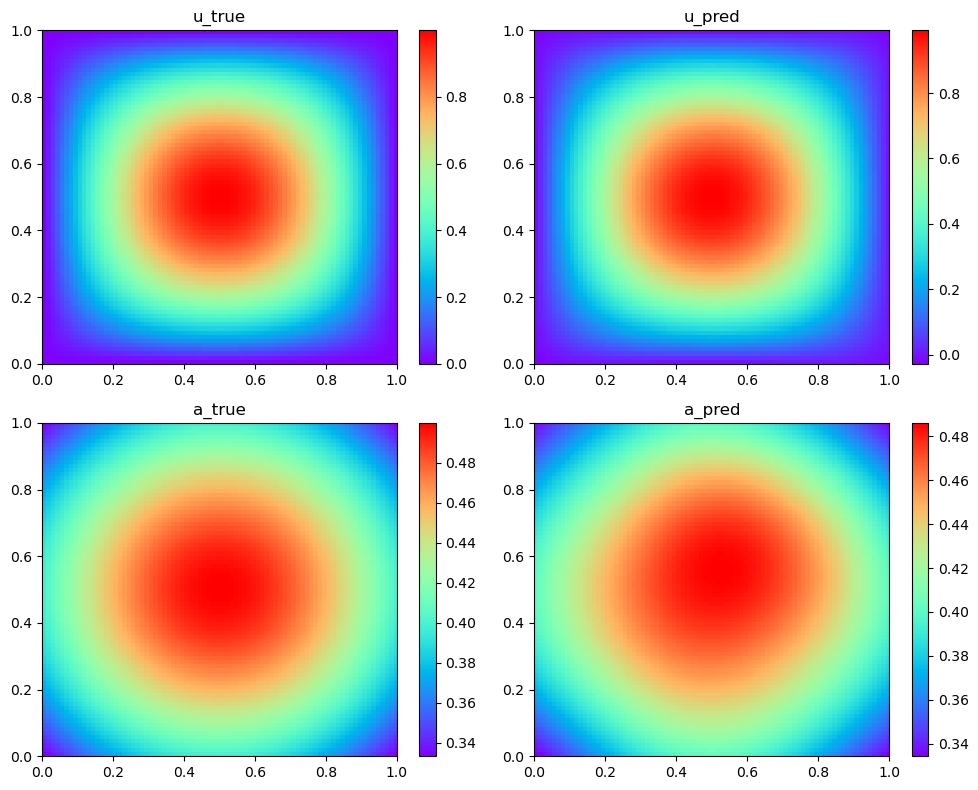

In [21]:

model_pruned = fine_tune(model_pruned, X_good, u_good, X_pde, X_b, u_b, a_b,
                                     epochs=2000, lr=1e-3, lambda_pde=0.001, lambda_b=1.0)
(u_metrics_a, a_metrics_a, u_pred, a_pred, u_true, a_true) = evaluate_model(model_pruned, nx=80, ny=80)
l2re_u, l1re_u, mse_u, max_err_u = u_metrics_a
l2re_a, l1re_a, mse_a, max_err_a = a_metrics_a
print(f"Final: rel_u={l2re_u:.6f}, rel_a={l2re_a:.6f}")

# (7) Visualization of results
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
im0 = axs[0, 0].imshow(u_true, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='rainbow')
axs[0, 0].set_title("u_true")
im1 = axs[0, 1].imshow(u_pred, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='rainbow')
axs[0, 1].set_title("u_pred")
im2 = axs[1, 0].imshow(a_true, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='rainbow')
axs[1, 0].set_title("a_true")
im3 = axs[1, 1].imshow(a_pred, origin='lower', extent=[0, 1, 0, 1], aspect='auto', cmap='rainbow')
axs[1, 1].set_title("a_pred")
plt.colorbar(im0, ax=axs[0, 0])
plt.colorbar(im1, ax=axs[0, 1])
plt.colorbar(im2, ax=axs[1, 0])
plt.colorbar(im3, ax=axs[1, 1])
plt.tight_layout()
plt.show()

In [22]:
def compute_frmse_bands_2d(u_pred, u_true, freq_bands=[(0,4), (5,12), (13,1e9)]):
    """
    Compute the FRMSE in different frequency bands for a 2D field.

    Parameters:
    -----------
    u_pred : 2D numpy array
        Predicted solution on a grid, shape (Nx, Ny).
    u_true : 2D numpy array
        True solution on the same grid, shape (Nx, Ny).
    freq_bands : list of tuples
        Each tuple is (k_min, k_max) defining a frequency range (radial index).
        Default is [(0,4), (5,12), (13,1e9)] for low, middle, and high frequencies.

    Returns:
    --------
    frmses : list of floats
        FRMSE for each band in the order of freq_bands.
    """

    # Dimensions
    Nx, Ny = u_pred.shape

    # 1) 2D FFT
    U_pred = np.fft.fft2(u_pred)
    U_true = np.fft.fft2(u_true)

    # 2) Shift zero frequency to the center
    D = U_pred - U_true
    D_shifted = np.fft.fftshift(D)

    # 3) Build frequency index arrays (k_x, k_y)
    #    np.fft.fftfreq gives frequencies in the range [-0.5, 0.5) * Nx (or Ny) if you multiply.
    freq_x = np.fft.fftfreq(Nx)  # in cycles per grid length
    freq_y = np.fft.fftfreq(Ny)
    # Shift them so that zero freq is at the center
    freq_x = np.fft.fftshift(freq_x) * Nx
    freq_y = np.fft.fftshift(freq_y) * Ny

    # Create 2D mesh for radial frequency
    fx_grid, fy_grid = np.meshgrid(freq_x, freq_y, indexing='ij')
    r = np.sqrt(fx_grid**2 + fy_grid**2)

    # 4) For each band, accumulate squared difference in that frequency range
    frmses = []
    magnitude_sq = np.abs(D_shifted)**2  # squared magnitude of difference in frequency domain

    for (kmin, kmax) in freq_bands:
        mask = (r >= kmin) & (r <= kmax)
        count = np.sum(mask)
        if count > 0:
            band_error = np.sum(magnitude_sq[mask])
            # FRMSE = sqrt( average of squared error in that band )
            frmse = np.sqrt(band_error / count)
        else:
            frmse = 0.0
        frmses.append(frmse)

    return frmses

def evaluate_frmse(u_pred, u_true):
    """
    Example wrapper to compute low/mid/high FRMSE for u_pred vs u_true.

    Returns a dictionary with 'low', 'middle', and 'high' FRMSE values.
    """
    bands = [(0, 4), (5, 12), (13, 1e9)]  # adjust as needed
    frmse_values = compute_frmse_bands_2d(u_pred, u_true, freq_bands=bands)
    return {
        "low_frmse": frmse_values[0],
        "mid_frmse": frmse_values[1],
        "high_frmse": frmse_values[2]
    }